In [1]:
%matplotlib inline

from functools import partial
from datetime import datetime

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

### Vanishing/Exploding Gradients
Xavier and He initialization

In [3]:
X = tf.placeholder(tf.float32, (None, 3), name="X")
n_hidden1 = 300

he_init = tf.contrib.layers.variance_scaling_initializer()
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name="Hidden1")

Activation Functions

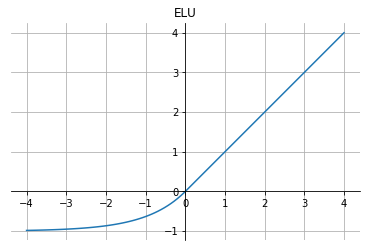

In [30]:
alpha = 1
lx = np.linspace(-4, 4, 100)
ly = list(map(lambda x: alpha*np.exp(x)-alpha if x<0 else x, lx))
fig, ax = plt.subplots()
fig.set_size_inches(10, 4)
# ax.xaxis.set_ticks_position('bottom')
# ax.yaxis.set_ticks_position('left')

ax.set_aspect('equal')
ax.grid(True, which='both')

# set the x-spine (see below for more info on `set_position`)
ax.spines['left'].set_position('zero')

# turn off the right spine/ticks
ax.spines['right'].set_color('none')
ax.yaxis.tick_left()

# set the y-spine
ax.spines['bottom'].set_position('zero')

# turn off the top spine/ticks
ax.spines['top'].set_color('none')
ax.xaxis.tick_bottom()


ax.plot(lx, ly)
ax.set_title("ELU")
plt.show()

In [ ]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name)

Batch Normalization

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid = X_test[:5000]
y_valid = y_test[:5000]

n_inputs = 28*28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10
n_epochs = 10
learning_rate = 0.01
batch_size = 50
threshold = 1.0
n_batches = X_train.shape[0]//batch_size

def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield (X_batch, y_batch)
        
def get_logdir():
    now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
    root_logdir = "tf_logs"
    return "{}/run-{}/".format(root_logdir, now)

In [4]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")
training = tf.placeholder_with_default(input=False, shape=(), name="training")

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1")
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name="hidden2")
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_outputs, name="outputs")
logits = my_batch_norm_layer(logits_before_bn)


with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads_vars = optimizer.compute_gradients(loss)
    capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_vars]
    training_op = optimizer.apply_gradients(capped_gvs)
#     training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float16))

init = tf.global_variables_initializer()
saver = tf.train.Saver()    
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y: y_batch})
            
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        
        print(epoch, "Test accuracy:", accuracy_val)
        save_path = saver.save(sess, "tmp/bn_model_final.ckpt")

0 Test accuracy: 0.905
1 Test accuracy: 0.9287
2 Test accuracy: 0.937
3 Test accuracy: 0.9434
4 Test accuracy: 0.952
5 Test accuracy: 0.954
6 Test accuracy: 0.956
7 Test accuracy: 0.959
8 Test accuracy: 0.9585
9 Test accuracy: 0.9614


### Reusing Pretrained Layers

In [43]:
tf.reset_default_graph()

saver = tf.train.import_meta_graph("tmp/mnist_model_final.ckpt.meta")

X = tf.get_default_graph().get_tensor_by_name("X:0")
y = tf.get_default_graph().get_tensor_by_name("y:0")
accuracy = tf.get_default_graph().get_tensor_by_name("eval/accuracy:0")
training_op = tf.get_default_graph().get_operation_by_name("train/GradientDescent")

In [44]:
for op in (X, y, accuracy, training_op):
    tf.add_to_collection("important_ops", op)
    
X, y, accuracy, training_op = tf.get_collection("important_ops")    

In [45]:
reuse_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope="hidden[123]")
reuse_vars_dict = dict([(var.op.name, var) for var in reuse_vars])
restore_saver = tf.train.Saver(reuse_vars_dict)

init = tf.global_variables_initializer()
saver = tf.train.Saver()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "tmp/mnist_model_final.ckpt")
    save_path = saver.save(sess, "tmp/hidden123_mnist_model_final.ckpt")

INFO:tensorflow:Restoring parameters from tmp/mnist_model_final.ckpt


Freezing the Lower Layers: fetch selected vars to optimizer

In [46]:
loss = tf.get_default_graph().get_tensor_by_name("loss/loss:0")

train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="hidden[34]|outputs")
training_op = optimizer.minimize(loss, var_list=train_vars)

Freezing the Lower Layers: add "stop gradient"

In [21]:
tf.reset_default_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
#     hidden2_stop = tf.stop_gradient(hidden2)
    hidden3 = tf.layers.dense(hidden2, 50, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, 25, activation=tf.nn.relu, name="hidden4")
    logits = tf.layers.dense(hidden4, n_outputs, name="outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy)
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)    
    
saver = tf.train.Saver()    
init = tf.global_variables_initializer()

In [24]:
with tf.Session() as sess:
    init.run()
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X:X_batch, y:y_batch})
        
        loss_test = sess.run(loss, feed_dict={X:X_test, y:y_test})
        print("Epoch:", epoch, "Test loss:", loss_test)
    
    save_path = saver.save(sess, "tmp/layers_x4_mnist_model_final.ckpt")

Test loss: 0.3198201
Test loss: 0.24075203
Test loss: 0.19596633
Test loss: 0.16589253
Test loss: 0.1499387
Test loss: 0.13555607
Test loss: 0.12521482
Test loss: 0.121826746
Test loss: 0.12452241
Test loss: 0.10719646


Caching the Frozen Layers

In [83]:
n_epochs = 100

tf.reset_default_graph()
tf.train.import_meta_graph("tmp/layers_x4_mnist_model_final.ckpt.meta")

restore_saver = tf.train.Saver()
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    restore_saver.restore(sess, "tmp/layers_x4_mnist_model_final.ckpt")
    
    hidden2 = tf.get_default_graph().get_tensor_by_name("dnn/hidden2/Relu:0")
    X = tf.get_default_graph().get_tensor_by_name("X:0")
    y = tf.get_default_graph().get_tensor_by_name("y:0")
    training_op = tf.get_default_graph().get_tensor_by_name("train/GradientDescent/update_outputs/bias/ApplyGradientDescent:0")
    loss = tf.get_default_graph().get_tensor_by_name("loss/Mean:0")
    
    h2_cache = sess.run([hidden2], feed_dict={X: X_train})
    
    for epoch in range(n_epochs):
        shuffled_idx = np.random.permutation(X_train.shape[0])
        hidden2_batches = np.array_split(h2_cache[0][shuffled_idx], n_batches)
        y_batches = np.array_split(y_train[shuffled_idx], n_batches)
        for hidden2_batch, y_batch in zip(hidden2_batches, y_batches):
            sess.run(training_op, feed_dict={hidden2:hidden2_batch, y:y_batch})
            
        loss_test = sess.run(loss, feed_dict={X:X_test, y:y_test})
        print("Epoch:", epoch, "Test loss:", loss_test)            
            
#     save_path = saver.save(sess, "tmp/cached_mnist_model_final.ckpt")
    

INFO:tensorflow:Restoring parameters from tmp/layers_x4_mnist_model_final.ckpt
Epoch: 0 Test loss: 0.10686793
Epoch: 1 Test loss: 0.10657914
Epoch: 2 Test loss: 0.10632399
Epoch: 3 Test loss: 0.10609763
Epoch: 4 Test loss: 0.10589534
Epoch: 5 Test loss: 0.105713986
Epoch: 6 Test loss: 0.10555039
Epoch: 7 Test loss: 0.105402514
Epoch: 8 Test loss: 0.10526825
Epoch: 9 Test loss: 0.10514573
Epoch: 10 Test loss: 0.10503374
Epoch: 11 Test loss: 0.10493043
Epoch: 12 Test loss: 0.104835495
Epoch: 13 Test loss: 0.104747646
Epoch: 14 Test loss: 0.10466616
Epoch: 15 Test loss: 0.1045906
Epoch: 16 Test loss: 0.1045198
Epoch: 17 Test loss: 0.10445415
Epoch: 18 Test loss: 0.10439314
Epoch: 19 Test loss: 0.10433577
Epoch: 20 Test loss: 0.10428163
Epoch: 21 Test loss: 0.1042312
Epoch: 22 Test loss: 0.10418347
Epoch: 23 Test loss: 0.10413814
Epoch: 24 Test loss: 0.10409582
Epoch: 25 Test loss: 0.10405599
Epoch: 26 Test loss: 0.104018286
Epoch: 27 Test loss: 0.10398276
Epoch: 28 Test loss: 0.103948794


### Faster Optimizers

In [3]:
optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9, use_nesterov=True)

In [3]:
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, momentum=0.9, decay=0.9, epsilon=1e-10)

In [11]:
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)